# Short-Term Crude Oil Scheduling using State-Task Networks and MILP

Dalton Flynn and Alexander Smith  
Fall 2017 Process Operations CBE 40455 Final Project

## Introduction

This project is motivated by and adapted from a paper called “Mixed-Integer Programming Approach for Short-Term Crude Oil Scheduling” published by L.F.L Moro and J.M. Pinto in 2004. In this paper, Moro and Pinto address the problem of crude oil inventory management of a real-world refinery that receives oil delivered through a pipeline.

Refineries often receive crude oil feed through a pipeline, which is linked to a docking station where oil tankers unload. The schedule of oil tankers is usually defined at the corporate level and cannot be modified by the refinery scheduler under normal conditions. Therefore, for a given short-term scheduling horizon, a refinery faces a set oil batch schedule [Moro and Pinto, 2004]. This project aims to optimize a refinery's profit over a time horizon of 1.5 days (36 hours) given a set schedule of oil shipments, a simple refinery composed of crude storage tanks, pumps and piping, and a distillation unit, and certain operational constraints that will be elaborated upon below.

Following the lead of Moro and Pinto, a Mixed-Integer Linear Programming approach is utilized here to optimize refinery profit. Additionally, a State-Task Network (STN) approach in discretized time was used to model the movement of crude from ship to crude tank to distillation unit. The STN is an approach to modeling multipurpose batch processes for the purpose of short-term scheduling. It was first developed by Kondili, et al., in 1993, and subsequently developed and extended by others. The system is modeled here in Pyomo and solved by the Gurobi Optimizer. This notebook begins from Professor J.C. Kantor's notebook "Scheduling Multipurpose Batch Processes using State-Task Networks" and builds in extra constraints and features, which will be described below.

## Refinery Problem Set-Up

A state-task network is a graphical representation of the activities in a multiproduct batch process. The representation includes the minimum details needed for short term scheduling of batch operations.

Each circular node in the diagram designates material in a particular state.  The materials are generally held in suitable vessels with a known capacity. The relevant information for each state is the initial inventory, storage capacity, and the unit price of the material in each state. For this refinery example, there are seven states: crude on the oil tanker before it has been unloaded (denoted the 'ship' state), crude in each of four tanks (denoted 'T1', 'T2', 'T3', and 'T4'), crude that has been fed to the distillation unit (denoted 'F_DU'), and the bottoms and distillate products leaving the distillation unit (denoted 'DandB'). 

The rectangular nodes denote process tasks. When scheduled for execution, each task is assigned an appropriate piece of equipment, and assigned a batch of material according to the incoming arcs. Each incoming arc begins at a state where the associated label indicates the mass fraction of the batch coming from that particular state. Outgoing arcs indicate the disposition of the batch to product states. The outgoing are labels indicate the fraction of the batch assigned to each product state, and the time necessary to produce that product. The tasks in this example take 3 forms: pumping to a crude tank (denoted by the form 'PtoTX' where X is any tank number); pumping to the distillation unit from any of the crude tanks (denoted by the form 'PtoDUfTX' where X is any tank number); and the distillation of crude (denoted by 'distill').

Not shown in the diagram is the process equipment used to execute the tasks. A separate list of process units is available, each characterized by a capacity and list of tasks which can be performed in that unit. For this example, there is one pump (denoted as 'Pump1') that is able to complete tasks of sending crude from a tanker to any of the crude tanks. Additionally, there are two pumps ('Pump2' and 'Pump3') that are capable of sending crude from a crude tank to the distillation unit. Finally, there is one distillation unit (denoted as 'DU') capable of performing the distillation task.

Additional information relevant to this problem:  
-The volume of a crude tank cannot drop below 20% of its maximum capacity. This is because the tanks employed are floating-roof tanks in order to minimize losses to vaporization within the tank.    
-The distilation unit has a maximum capacity of 2000 $m^3$.  
-The cost of using a tank is assumed to be \$1,000,000 annually. This is to pay for 24/7 operators to sample from and perform maintenance on the tank. This also pays for maintenance and parts on the tank.  
-A brine settling time of 3 hours is required. Chaning this amount of time is explored in the example.  
-A pumping cost of \$1000 per $m^3$ is assigned.  
-Pump1 can pump at a rate of 5000$m^3$/hr while Pump2 and Pump3 can pump at rates of 2000$m^3$/hr. These rates will also be explored.  
-The distillation unit can distill a maximum of 2000$m^3$/hr of crude. Additionally, it must distill at least 1000$m^3$/hr.    
-The price of refined crude (distillate and bottoms product) is calculated as weighted average of revenues available from gasoline, diesel, and jet fuel. It comes to roughly \$866/$m^3$.  
-The shipment schedule within the 36 hour time horizon is: 1) at time 6, 10,000$m^3$ of crude arrive; 2) at time 12, 15,000$m^3$ of crude arrive; 3) at time 24, 25,000$m^3$ of crude arrive.

Below is a dictionary composed of the states, tasks, units, and arcs tying them together. This dictionary also includes relevant capacity constraints, maximum and minimum unit loads, etc. In Figure 1 below this dictionary is the STN diagram.

In [3]:
H = 36 # hours

con = 0 # cost to turn pump on
cvar = 1*1000 # cost for each m^3 pumped 
# from https://www.engineeringtoolbox.com/water-pumping-costs-d_1527.html
# with assumption pumping crude is roughly 10 times as costly as pumping water
# due to viscosity differences

tankcost = 1e6/365/24*H*1000 # savings possible assuming $1,000,000 annual savings
# for each tank not used

tpump = 1 # hrs to pump 2000 m^3 for pumps 2,3 and 5000 m^3 for pump 1
tstill = 1 # hrs to distill 2000 m^3

tsettle = 3 # hrs required for brine to settle in crude before it can be sent to the distillation unit (DU)

shiploads = {6:10,
            12:15,
            24:25} # key:value is time:amount of crude shipment

pdcrude = ((20/36)*2.5+(12/36)*3+(4/36)*8)*(264.172)*1000
# https://www.eia.gov/energyexplained/index.cfm?page=oil_refining

# all amounts are in thousands, all costs/prices are in USD
Kondili = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Ship'     : {'capacity': 200  , 'minimum': 0   ,'initial': 15  , 'price':  0},
        'T1'       : {'capacity': 50   , 'minimum': 10  ,'initial': 15  , 'price':  0},
        'T2'       : {'capacity': 50   , 'minimum': 10  ,'initial': 15  , 'price':  0},
        'T3'       : {'capacity': 50   , 'minimum': 10  ,'initial': 20  , 'price':  0},
        'T4'       : {'capacity': 50   , 'minimum': 10  ,'initial': 15  , 'price':  0},
        'F_DU'     : {'capacity': 2    , 'minimum': 0   ,'initial': 2   , 'price':  0},
        'DandB'    : {'capacity': 400  , 'minimum': 0   ,'initial': 0   , 'price':  pdcrude}
    },
    'ST_ARCS': {
        ('Ship'  ,   'PtoT1')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT2')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT3')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT4')     : {'rho': 1.0},
        ('T1'    ,   'PtoDUfT1')  : {'rho': 1.0},
        ('T2'    ,   'PtoDUfT2')  : {'rho': 1.0},
        ('T3'    ,   'PtoDUfT3')  : {'rho': 1.0},
        ('T4'    ,   'PtoDUfT4')  : {'rho': 1.0},
        ('F_DU'  ,   'Distill')   : {'rho': 1.0}
    },
    'TS_ARCS': {
        ('PtoT1'     , 'T1')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT2'     , 'T2')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT3'     , 'T3')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT4'     , 'T4')       : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT1'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT2'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT3'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT4'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('Distill'   , 'DandB')    : {'dur': tstill, 'rho': 1.0}
    },
    'UNIT_TASKS': {
        ('Pump1'    , 'PtoT1')     : {'Bmin': 0, 'Bmax': 3, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT2')     : {'Bmin': 0, 'Bmax': 3, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT3')     : {'Bmin': 0, 'Bmax': 3, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT4')     : {'Bmin': 0, 'Bmax': 3, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT1')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT1')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT2')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT2')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT3')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT3')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT4')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT4')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('DU'       , 'Distill')   : {'Bmin': 1, 'Bmax': 2, 'Cost': 0  , 'vCost': 0   , 'Tclean': 0}
    },
}

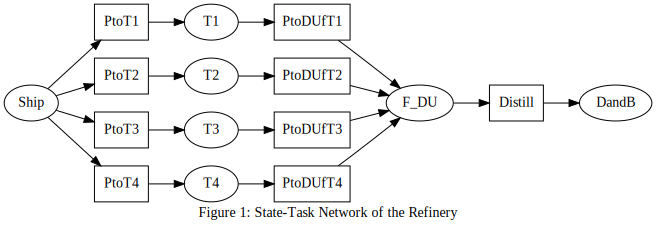

In [4]:
# create STN flowchart from nodes input
from graphviz import Digraph

dot = Digraph()
dot.graph_attr['rankdir'] = 'LR'
dot.graph_attr['label'] = 'Figure 1: State-Task Network of the Refinery'
dot.graph_attr['labeljust'] = 'centered'
dot.graph_attr['labelloc'] = 'b'
dot.graph_attr['fontsize'] = '14'

for s in Kondili['STATES']:
    dot.node(s,s)
    
for i in sorted(Kondili['UNIT_TASKS']):
    dot.node(i[1],i[1],shape='rect')

for i in sorted(Kondili['ST_ARCS'].keys()):
    s = i[0]
    t = i[1]
    dot.edge(s,t)

for i in Kondili['TS_ARCS'].keys():
    t = i[0]
    s = i[1]
    dot.edge(t,s)
    
dot

### Setting a Time Grid

The following computations can be done on any time grid, including real-valued time points. TIME is a list of time points commencing at 0.

## Creating a Pyomo Model

The following Pyomo model closely follows the development in Kondili, et al. (1993). In particular, the first step in the model is to process the STN data to create sets as given in Kondili.  

One important difference from Kondili is the adoption of a more natural time scale that starts at $t = 0$ and extends to $t = H$ (rather than from 1 to H+1).

A second difference is the introduction of an additional decision variable denoted by $Q_{j,t}$ indicating the amount of material in unit $j$ at time $t$. A material balance then reads

\begin{align*}
Q_{jt} & = Q_{j(t-1)} + \sum_{i\in I_j}B_{ijt} - \sum_{i\in I_j}\sum_{\substack{s \in \bar{S}_i\\s\ni t-P_{is} \geq 0}}\bar{\rho}_{is}B_{ij(t-P_{is})} \qquad \forall j,t
\end{align*}

Following Kondili's notation, $I_j$ is the set of tasks that can be performed in unit $j$, and $\bar{S}_i$ is the set of states fed by task $j$.

The unit allocation constraints are written the full backward aggregation method described by Shah (1993).  The allocation constraint reads

\begin{align*}
\sum_{i \in I_j} \sum_{t'=t}^{t-p_i+1} W_{ijt'} & \leq 1 \qquad \forall j,t
\end{align*}

Each processing unit $j$ is tagged with a minimum and maximum capacity, $B_{ij}^{min}$ and $B_{ij}^{max}$, respectively, denoting the minimum and maximum batch sizes for each task $i$. A minimum capacity may be needed to cover heat exchange coils in a reactor or mixing blades in a blender, for example. The capacity may depend on the nature of the task being performed.  These constraints are written

\begin{align*}
B_{ij}^{min}W_{ijt} & \leq B_{ijt} \leq  B_{ij}^{max}W_{ijt} \qquad \forall j, \forall i\in I_j, \forall t
\end{align*}


### Additional Constraints
#### Settling Time:

After crude is pumped into a crude tank, it must be given time to settle so that the brine can separate from the crude. No crude can be sent to the distillation tower from a tank that has not allowed the brine to settle out of the crude. Therefore, the following constraints must be added to the model:

\begin{align*}
\sum_{i \in T_s} \sum_{j \in K_i} W_{ijt} + \sum_{t'=t-tsettle}^{t} \sum_{i \in \bar{T_s}} \sum_{j \in K_i} W_{ijt} & \leq 1 \qquad \forall t,s \in TANKS
\end{align*}


#### Cost of Each Additional Tank:

Each tank in operation requires a team of operators for sampling, draining, maintenance, and cleaning. Therefore, minimizing the number of tanks is part of maximizing profit. A new binary variable, TOO, was added for each tank. If TOO is 1, the tank has been used. If TOO is 0, the tank is not used. An annual cost of \$1,000,000 is estimated for the use of each tank. 36 hours worth of this cost is accrued to this time horizon. The objective function has the is added for each TOO that has a value of 1. The following constraint is then added to ensure if a tank is used at all the corresponding TOO binary variable is set to 1.

\begin{align*}
\sum_{i \in T_s} \sum_{j \in K_i} W_{ijt} + \sum_{i \in \bar{T_s}} \sum_{j \in K_i} W_{ijt} = (\sum_{i \in T_s} \sum_{j \in K_i} W_{ijt} + \sum_{i \in \bar{T_s}} \sum_{j \in K_i} W_{ijt})*TOO_s \qquad
\forall t,s \in TANKS
\end{align*}


#### Continuous Feed to Distillation Unit:

Because shut down and start up of the distillation unit are extremely costly, the distillation unit must always be running during the time horizon. Additionally, the unit is constrained by a Bmin of 1000 $m^3$/hr and Bmax of 2000 $m^3$/hr. Thus the following constraint is added:

\begin{align*}
W_{Distill,DU,t} = 1 \qquad
\end{align*}

for t = 0 to to t = H-1.


#### Previous Oil Tanker Must be Emptied Before Next Arrives:

A schedule of oil tanker loads is given. The previous oil tanker must be emptied (evident in the 'Ship' state being empty) before the next arrive. Thus the following constraint is added:

\begin{align*}
S_{Ship,t} = 0 \qquad
\forall t \in t_{ship}
\end{align*}

#### Only One Tank Can Receive Oil from an Oil Tanker at a Time:



### Characterization of Tasks

In [5]:
STN = Kondili

STATES = STN['STATES']
TANKS = ['T1','T2','T3','T4']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)

In [6]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j) 

### Characterization of States

In [7]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C  = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s
MV = {s: STATES[s]['minimum'] for s in STATES}                    # MV[s] minimum volume allowed in state s

### Characterization of Units

In [8]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

### Pyomo Model

In [24]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.TOO = Var(TANKS, domain=Boolean)                        # TOO[s in TANKS] boolean: if 1, tank was used, if 0, tank was not used
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state (see Kondili, Sec. 5)
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()
model.cons.add(model.Value == sum([STATES[s]['price']*model.S[s,H] for s in STATES]))
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])+ 
               sum([model.TOO[tk]*tankcost for tk in TANKS])) 

# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Kondili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]

# state mass balance constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        model.cons.add(model.S[s,t] >= MV[s])
        
        # accounting for shipload schedule
        if t in shiploads.keys() and s == 'Ship':
            rhs += shiploads[t]
            
        # state mass balanaces
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
                                                                 
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t]
        
        # require previous ship to have emptied crude before next comes
        if t in shiploads.keys() and s == 'Ship':
            model.cons.add(model.S[s,t-1] == 0)

# tank brine settling time constraint, tank cost constraint
for tk in TANKS:
    Wsumforcost = 0 # sum of decision variables to see if a tank was used over the time period
    for t in TIME:
        Wsums = 0 # sum of decision variables to determine if settling has completed
        for i in T[tk]:
            for j in K[i]:
                Wsums += model.W[i,j,t] # add decision variables for pumping away from tank
                Wsumforcost += model.W[i,j,t] # add decision variables for pumping away from tank
                
        for i in T_[tk]:
            for j in K[i]:
                for ts in range(0,tsettle+1):
                    Wsums += model.W[i,j,t-min(t,ts)] # add decision variables for sending material to tank within tsettle
        model.cons.add(Wsums <= 1)
        
        for i in T_[tk]:
            for j in K[i]:
                Wsumforcost += model.W[i,j,t]
        
    model.cons.add(Wsumforcost == Wsumforcost*model.TOO[tk]) # tank cost constraint: if any crude is pumped away from tank, boolean TOO is turned on
    

# Distillation unit can never shut down (this is very costly)
for t in TIME[:-1]:
    model.cons.add(model.W['Distill','DU',t] == 1)


SolverFactory('gurobi').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x3078
  Lower bound: 44063441.6134
  Upper bound: 44063441.6134
  Number of objectives: 1
  Number of constraints: 2229
  Number of variables: 1376
  Number of binary variables: 485
  Number of integer variables: 485
  Number of continuous variables: 891
  Number of nonzeros: 6535
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model wa

## Analysis

### Profitability



In [25]:
print("Value of State Inventories = ${0:12,.2f}".format(model.Value()))
print("  Cost of Unit Assignments = ${0:12,.2f}".format(model.Cost()))
print("             Net Objective = ${0:12,.2f}".format(model.Value() - model.Cost()))

Value of State Inventories = $60,612,797.78
  Cost of Unit Assignments = $16,549,356.16
             Net Objective = $44,063,441.61


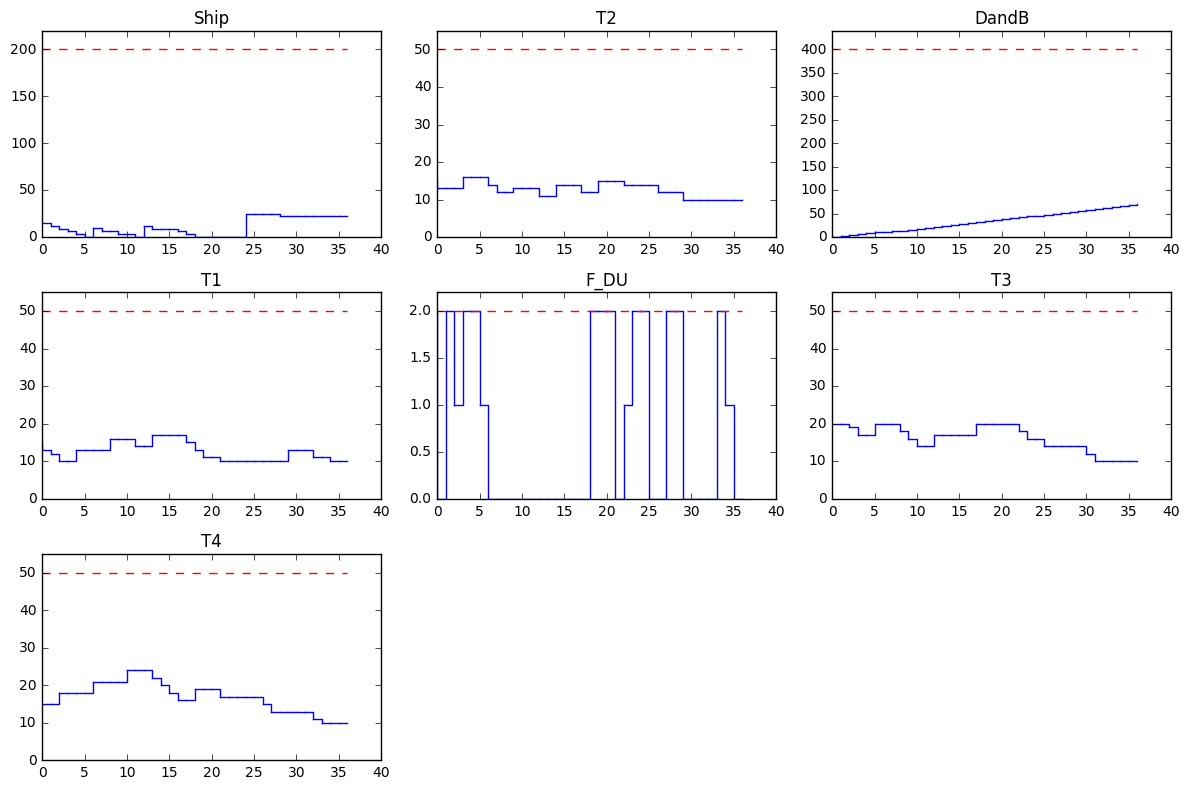

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()


### Gannt Chart

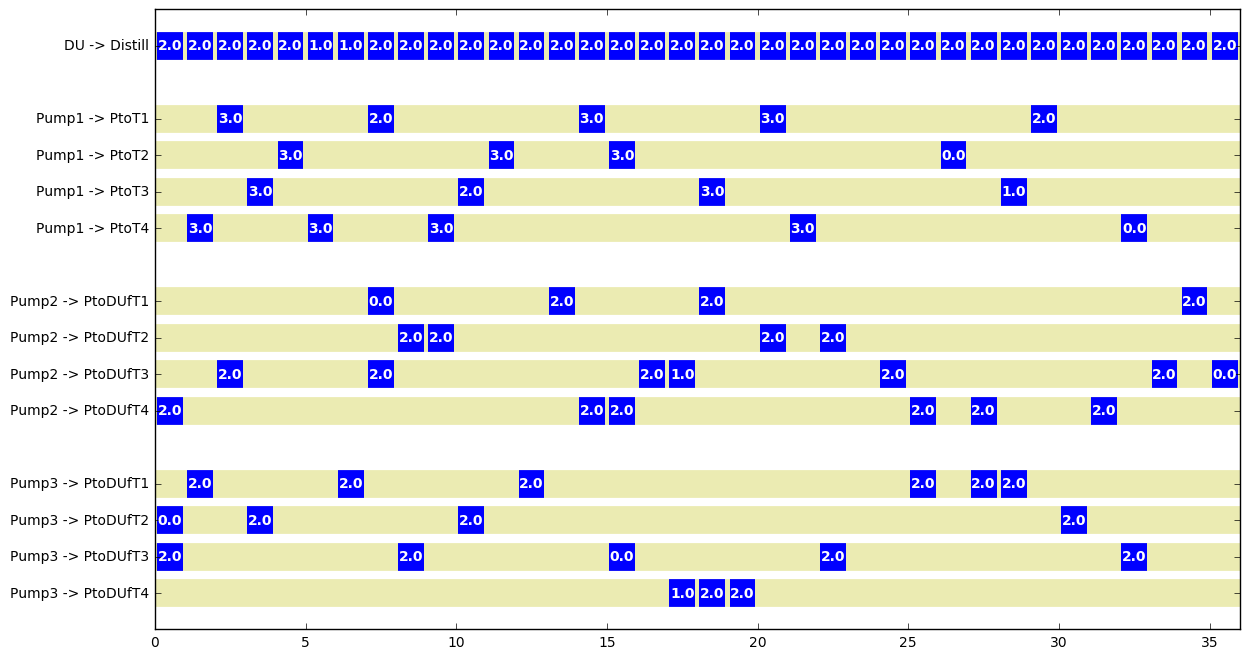

In [30]:
plt.figure(figsize=(14,8))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.1f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
idx -= 1
ticks.append(idx)
lbls.append('')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

### State Inventories

In [31]:
import pandas as pd
from IPython.display import display, HTML

pd.DataFrame([[model.S[s,t]() for s in STATES.keys()] for t in TIME], columns = STATES.keys(), index = TIME)

,T1,T3,T4,Ship,DandB,T2,F_DU
0,15.0,18.0,13.0,15.0,0.0,15.0,-2.287059e-13
1,13.0,18.0,13.0,12.0,2.0,15.0,2.000000e+00
2,13.0,16.0,16.0,9.0,4.0,15.0,2.000000e+00
3,16.0,16.0,16.0,6.0,6.0,13.0,2.000000e+00
4,16.0,19.0,16.0,3.0,8.0,13.0,2.000000e+00
5,16.0,19.0,16.0,0.0,10.0,16.0,1.000000e+00
6,14.0,19.0,19.0,10.0,11.0,16.0,0.000000e+00
7,14.0,17.0,19.0,8.0,12.0,16.0,0.000000e+00
8,16.0,15.0,19.0,8.0,14.0,14.0,-2.298162e-13
9,16.0,15.0,19.0,5.0,16.0,12.0,2.000000e+00


### Unit Assignment

In [102]:
UnitAssignment = pd.DataFrame({j:[None for t in TIME] for j in UNITS},index=TIME)

for t in TIME:
    for j in UNITS:
        for i in I[j]:
            for s in S_[i]:
                if t-p[i] >= 0:
                    if model.W[i,j,max(TIME[TIME <= t-p[i]])]() > 0:
                        UnitAssignment.loc[t,j] = None               
        for i in I[j]:
            if model.W[i,j,t]() > 0:
                UnitAssignment.loc[t,j] = (i,model.B[i,j,t]())

UnitAssignment

,DU,Pump1,Pump2,Pump3
0,"(Distill, 2.0)","(PtoT1, 1.0)","(PtoDUfT2, 2.0)","(PtoDUfT3, 2.0)"
1,"(Distill, 2.0)","(PtoT1, 5.0)","(PtoDUfT2, 2.0)",None
2,"(Distill, 2.0)",None,None,"(PtoDUfT1, 2.0)"
3,"(Distill, 2.0)","(PtoT3, 5.0)",None,None
4,"(Distill, 2.0)","(PtoT2, 4.0)","(PtoDUfT1, 2.0)",None
5,"(Distill, 2.0)",None,"(PtoDUfT1, 2.0)",None
6,"(Distill, 2.0)",None,None,"(PtoDUfT1, 2.0)"
7,"(Distill, 2.0)","(PtoT2, 5.0)","(PtoDUfT1, 2.0)","(PtoDUfT3, 2.0)"
8,"(Distill, 2.0)",None,None,"(PtoDUfT3, 2.0)"
9,"(Distill, 2.0)","(PtoT1, 5.0)","(PtoDUfT2, 2.0)",None


### Unit Batch Inventories

In [23]:
pd.DataFrame([[model.Q[j,t]() for j in UNITS] for t in TIME], columns = UNITS, index = TIME)

,Pump3,Pump2,DU,Pump1
0,5.000000e+03,5.000000e+03,5000.0,0.000000e+00
1,5.000000e+03,0.000000e+00,5000.0,5.000000e+03
2,5.000000e+03,0.000000e+00,5000.0,5.000000e+03
3,5.000000e+03,0.000000e+00,5000.0,0.000000e+00
4,5.000000e+03,0.000000e+00,5000.0,5.000000e+03
5,9.992007e-12,5.000000e+03,5000.0,5.000000e+03
6,2.314593e-12,5.000000e+03,5000.0,7.771561e-12
7,0.000000e+00,1.000000e+03,5000.0,5.000000e+03
8,5.000000e+03,0.000000e+00,5000.0,5.000000e+03
9,0.000000e+00,4.000000e+03,5000.0,7.771561e-12


In [26]:
model.B['PtoDUfT2','Pump3',15].value

0.0

## Trace of Events and States

In [13]:
sep = '\n--------------------------------------------------------------------------------------------\n'
print(sep)
print("Starting Conditions")
print("    Initial Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,STATES[s]['initial']))
        
units = {j:{'assignment':'None', 't':0} for j in UNITS}

for t in TIME:
    print(sep)
    print("Time =",t,"hr")
    print("    Instructions:")
    for j in UNITS:
        units[j]['t'] += 1
        # transfer from unit to states
        for i in I[j]:  
            for s in S_[i]:
                if t-P[(i,s)] >= 0:
                    amt = rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t - P[(i,s)]])]()
                    if amt > 0:
                        print("        Transfer", amt, "kg from", j, "to", s)
    for j in UNITS:
        # release units from tasks
        for i in I[j]:
            if t-p[i] >= 0:
                if model.W[i,j,max(TIME[TIME <= t-p[i]])]() > 0:
                    print("        Release", j, "from", i)
                    units[j]['assignment'] = 'None'
                    units[j]['t'] = 0
        # assign units to tasks             
        for i in I[j]:
            if model.W[i,j,t]() > 0:
                print("        Assign", j, "with capacity", Bmax[(i,j)], "kg to task",i,"for",p[i],"hours")
                units[j]['assignment'] = i
                units[j]['t'] = 1
        # transfer from states to starting tasks
        for i in I[j]:
            for s in S[i]:
                amt = rho[(i,s)]*model.B[i,j,t]()
                if amt > 0:
                    print("        Transfer", amt,"kg from", s, "to", j)
    print("\n    Inventories are now:")            
    for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,model.S[s,t]()))
    print("\n    Unit Assignments are now:")
    for j in UNITS:
        if units[j]['assignment'] != 'None':
            fmt = "        {0:s} performs the {1:s} task with a {2:.2f} kg batch for hour {3:d} of {4:d}"
            i = units[j]['assignment']
            print(fmt.format(j,i,model.Q[j,t](),units[j]['t'],p[i]))
            
print(sep)
print('Final Conditions')
print("    Final Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,model.S[s,H]()))



--------------------------------------------------------------------------------------------

Starting Conditions
    Initial Inventories:
        Int_BC         0.0 kg
        Feed_A       500.0 kg
        Impure_E       0.0 kg
        Product_1      0.0 kg
        Product_2      0.0 kg
        Int_AB         0.0 kg
        Hot_A          0.0 kg
        Feed_C       500.0 kg
        Feed_B       500.0 kg

--------------------------------------------------------------------------------------------

Time = 0 hr
    Instructions:
        Assign Reactor_2 with capacity 50 kg to task Reaction_1 for 2 hours
        Transfer 25.0 kg from Feed_B to Reactor_2
        Transfer 25.0 kg from Feed_C to Reactor_2
        Assign Reactor_1 with capacity 80 kg to task Reaction_1 for 2 hours
        Transfer 38.0 kg from Feed_B to Reactor_1
        Transfer 38.0 kg from Feed_C to Reactor_1

    Inventories are now:
        Int_BC         0.0 kg
        Feed_A       500.0 kg
        Impure_E       0.0 

### References

Floudas, C. A., & Lin, X. (2005). Mixed integer linear programming in process scheduling: Modeling, algorithms, and applications. Annals of Operations Research, 139(1), 131-162.

Harjunkoski, I., Maravelias, C. T., Bongers, P., Castro, P. M., Engell, S., Grossmann, I. E., ... & Wassick, J. (2014). Scope for industrial applications of production scheduling models and solution methods. Computers & Chemical Engineering, 62, 161-193.

Kondili, E., Pantelides, C. C., & Sargent, R. W. H. (1993). A general algorithm for short-term scheduling of batch operations—I. MILP formulation. Computers & Chemical Engineering, 17(2), 211-227.

Méndez, C. A., Cerdá, J., Grossmann, I. E., Harjunkoski, I., & Fahl, M. (2006). State-of-the-art review of optimization methods for short-term scheduling of batch processes. Computers & Chemical Engineering, 30(6), 913-946.

Shah, N., Pantelides, C. C., & Sargent, R. W. H. (1993). A general algorithm for short-term scheduling of batch operations—II. Computational issues. Computers & Chemical Engineering, 17(2), 229-244.

Wassick, J. M., & Ferrio, J. (2011). Extending the resource task network for industrial applications. Computers & chemical engineering, 35(10), 2124-2140.

In [7]:
# from pyomo.environ import *
# import numpy as np

# TIME = np.array(TIME)

# model = ConcreteModel()

# model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
# model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
# model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
# model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
# model.Cost = Var(domain=NonNegativeReals)
# model.Value = Var(domain=NonNegativeReals)
# # Objective is to maximize the value of the final state (see Kondili, Sec. 5)
# model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# # Constraints
# model.cons = ConstraintList()

# for tk in TANKS:
#     for t in TIME:
#         Wsum = []
#         for i in T[tk]:
#             for j in K[i]:
#                 Wsum.append([i,j,t])
#         for i in T_[tk]:
#             for j in K[i]:
#                 for ts in range(0,tsettle):
#                     Wsum.append([i,j,t-min(t,ts)])
#         print(Wsum)

# no 2 tanks fed at same time
# for t in TIME:
#     newc = []
#     for tk in TANKS:
#         for i in T_[tk]:
#             for j in K[i]:
#                 newc.append([i,j,t])
#     print(newc)

# distillation tower always fed
# for t in TIME:
#     newc = []
#     for i in T_['inDU']:
#         for j in K[i]:
#             newc.append([i,j,t])
#     print(newc)
# for t in TIME:
#     Bsumcd = 0
#     for i in T_['inDU']:
#         for j in K[i]:
#             Bsumcd += model.B[i,j,t]
#     model.cons.add(Bsumcd >= 1)

# model.pprint()


# distillation tower must always be fed above 1000 m^3/hr but cannot be fed more than target value of 2000 m^3/hr
# for t in TIME[:-1]:
#     Bsumcd = 0 # sum of material that is sent to distillation unit
#     for i in T_['F_DU']:
#         for j in K[i]:
#             Bsumcd += model.B[i,j,t-min(t,1)]
#     model.cons.add(Bsumcd >= 1)
#     model.cons.add(Bsumcd <= 2)

In [148]:
for i in T.values():
    print(i)

{'PtoDUfT3'}
{'Distill'}
set()
{'PtoDUfT2'}
{'PtoT2', 'PtoT1', 'PtoT3'}
{'PtoDUfT1'}


<font color='red'> 1.5 days (36 hours) </font>